# Tutorial:
## Logistic regression for factor mapping
This analysis performs scenario discovery through the use of logistic regression
on three water users in a multi-stakeholder basin.

The analysis is performed on data generated during a previous experiment, detailed at
[Hadjimichael et al. (2020)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020EF001503).

The experiment employed exploratory modeling to assess the impacts of several (hydrologic,
infrastructural, societal) uncertain factors on water shortages experienced in a river basin in
Colorado.

<img src="./figs/basin_map.pdf" width="300">

Focusing on decision-relevant metrics, the scenario discovery is applied to the shortages experienced
by each individual user (i.e., not on a single basin-wide or sector-wide metric). For this training
example, we'll be using three different water users, two irrigation users and one municipal user.

Scenario discovery attempts to identify parametric regions that lead to 'success'
and 'failure'. For this demonstration we'll be defining 'success' as states of
the world where a shortage level doesn't exceed its historical frequency. We would
like to therefore identify the factor values that cause a user to experience a
historical shortage with increased frequency.

In [5]:
import pandas as pd
from utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

## Step 1:  Load Latin Hypercube Sample and set up problem
The heatmaps files contain the occurence of different frequency and magnitude combinations
under experiment the experiment, in increments of 10, between 0 and 100. These combinations (100
for each user) are alternative decision-relevant metrics that can be used for scenario discovery.
The pseudo r scores files contain preliminary logistic regression results on parameter
importance for each of these combinations. Using these pseudo r scores we will identify the
two most important factors for each metric and use to generate the final scenario discovery maps.

In [12]:
all_IDs = ['7000550','7200799','3704614'] # three users for whom to perform the analysis
usernames = ['Medium seniority irrigation',
             'Low seniority irrigation',
             'Transbasin municipal diversion']
nStructures = len(all_IDs)
LHsamples = np.loadtxt('./data/LHsamples_original_1000.txt')
param_bounds=np.loadtxt('./data/uncertain_params_bounds.txt', usecols=(1,2))
realizations = 10

param_names=['Irrigation demand multiplier','Reservoir loss','Transbasin demand multiplier',
             'Municipal & industrial multiplier', 'Shoshone','Environmental flows',
             'Evaporation change','Mean dry flow','Dry flow variance',
             'Mean wet flow','Wet flow variance','Dry-dry probability',
             'Wet-wet probability', 'Snowmelt shift']

SOW_values = np.array([1,1,1,1,0,0,1,1,1,1,1,0,0,0]) # default parameter values for base SOW

# Set arrays for shortage frequencies and magnitudes
frequencies = np.arange(10, 110, 10)
magnitudes = np.arange(10, 110, 10)

# Load performance and pseudo r scores for each of the users
heatmaps = [load_performance(all_IDs[i])/100 for i in range(len(all_IDs))]
scores = [pd.read_csv('./data/' + all_IDs[i] + '_pseudo_r_scores.csv', sep=",") for i in range(len(all_IDs))]

## Step 2: Define decision-relevant metrics for illustration

In [7]:
freq = [1,0,0]
mag = [7,3,7]

## Step 3: Draw factor maps

Optimization terminated successfully.
         Current function value: 0.378619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397285
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377323
         Iterations 8


/Users/antonia/Documents/nanites/notebooks/utils.py:29: UserWarning: The following kwargs were not used by contour: 'aspect'
  contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap, aspect='auto')
/Users/antonia/opt/anaconda3/envs/nanites/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/antonia/opt/anaconda3/envs/nanites/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


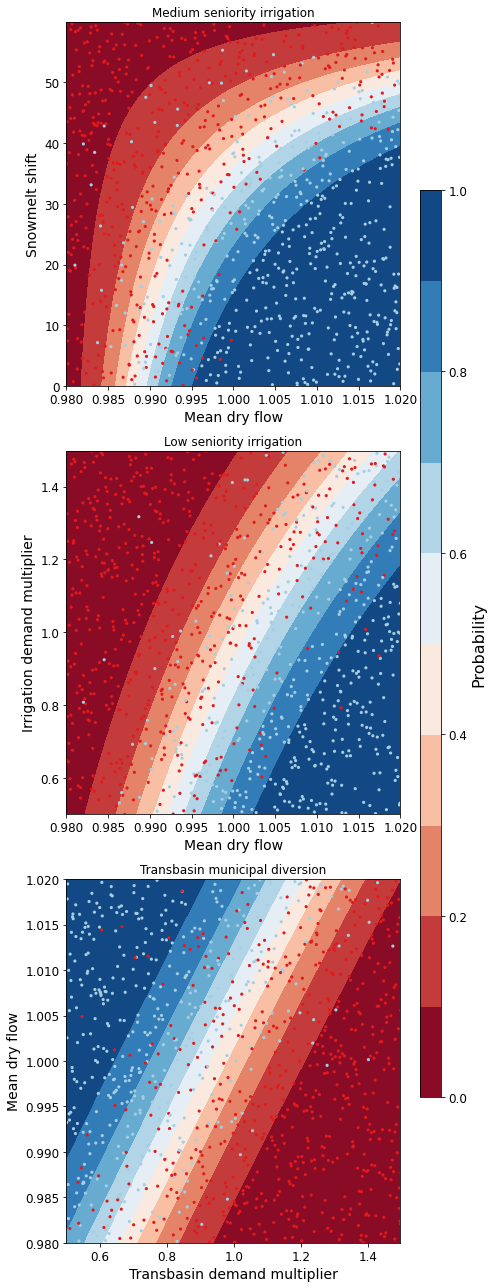

In [21]:
fig, axes = plt.subplots(3,1, figsize=(6,18), tight_layout=True)
fig.patch.set_facecolor('white')
for i in range(len(axes.flat)):
    ax = axes.flat[i]
    allSOWsperformance = heatmaps[i]
    all_pseudo_r_scores = scores[i]
    dta = pd.DataFrame(data = np.repeat(LHsamples, realizations, axis = 0), columns=param_names)
    dta['Success']=allSOWsperformance[freq[i],mag[i],:]
    pseudo_r_scores=all_pseudo_r_scores[str(frequencies[freq[i]])+'yrs_'+str(magnitudes[mag[i]])+'prc'].values
    top_predictors = np.argsort(pseudo_r_scores)[::-1][:2] #Sort scores and pick top 2 predictors
    # define color map for dots representing SOWs in which the policy
    # succeeds (light blue) and fails (dark red)
    dot_cmap = mpl.colors.ListedColormap(np.array([[227,26,28],[166,206,227]])/255.0)
    # define color map for probability contours
    contour_cmap = mpl.cm.get_cmap('RdBu')
    # define probability contours
    contour_levels = np.arange(0.0, 1.05,0.1)
    # define base values of the predictors
    base = SOW_values[top_predictors]
    ranges = param_bounds[top_predictors]
    # define grid of x (1st predictor), and y (2nd predictor) dimensions
    # to plot contour map over
    xgrid = np.arange(param_bounds[top_predictors[0]][0],
                      param_bounds[top_predictors[0]][1], np.around((ranges[0][1]-ranges[0][0])/500,decimals=4))
    ygrid = np.arange(param_bounds[top_predictors[1]][0],
                      param_bounds[top_predictors[1]][1], np.around((ranges[1][1]-ranges[1][0])/500,decimals=4))
    all_predictors = [ dta.columns.tolist()[i] for i in top_predictors]
    dta['Interaction'] = dta[all_predictors[0]]*dta[all_predictors[1]]
    result = fitLogit(dta, [all_predictors[i] for i in [0,1]])
    contourset = plotContourMap(ax, result, dta, contour_cmap,
                                dot_cmap, contour_levels, xgrid,
                                ygrid, all_predictors[0], all_predictors[1], base)
    ax.set_title(usernames[i])
cbar_ax = fig.add_axes([0.98, 0.15, 0.05, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax)
cbar_ax.set_ylabel('Probability', fontsize=16)
cbar_ax.tick_params(axis='y', which='major', labelsize=12)

Several insights can be drawn from this figure.

First, that using metrics chosen to be decision-relevant, i.e, specific to each
user, different factors are identified as most important by this scenario-discovery
exercise (the x- and y-axes for each of the subplots). In other words, depending
on what the decision makers of this system want to prioritize they might choose to
monitor different uncertain factors to track performance.

Second, for the top panel the two identified factors appear to also have an interactive
effect on the metric used (shortages of a certain level and frequency in this example).
In terms of scenario discovery, the Patient Rule Induction Method (PRIM) or Classification
And Regression Trees (CART) would not be able to delineate this non-linear space and
would therefore misclassify parameter combinations as 'desirable' when they were in
fact undesirable, and vice versa.

Lastly, logistic regression also produces contours of probability of success, i.e.
different factor-value combinations are assigned different probabilities that a
shortage level will be exceeded. This allows the decision makers to evaluate these
insights while considering their risk aversion. 